In [7]:
import pennylane.numpy as np 
import matplotlib.pyplot as plt 
import pennylane as qml 
from VarQFT import QFT, classical_swaps

In [8]:
import warnings
from typing import Sequence, Tuple
from pennylane.wires import Wires
from pennylane.measurements import SampleMeasurement, StateMeasurement

class MyMP(SampleMeasurement, StateMeasurement):

    def process_samples(
        self,
        samples: Sequence[complex],
        wire_order: Wires,
        shot_range: Tuple[int] = None,
        bin_size: int = None,
    ):
        # estimate the ev
        # This also covers statistics for mid-circuit measurements manipulated using
        # arithmetic operators
        eigvals = qml.math.asarray(self.eigvals(), dtype="float64")
        with qml.queuing.QueuingManager.stop_recording():
            prob = qml.probs(wires=self.wires).process_samples(
                samples=samples, wire_order=wire_order, shot_range=shot_range, bin_size=bin_size
            )

        prob = classical_swaps( prob, len(self.wires) )
        return qml.math.dot(prob, eigvals)


    def process_state(self, state: Sequence[complex], wire_order: Wires):
        # This also covers statistics for mid-circuit measurements manipulated using
        # arithmetic operators
        eigvals = qml.math.asarray(self.eigvals(), dtype="float64")
        # we use ``self.wires`` instead of ``self.obs`` because the observable was
        # already applied to the state
        with qml.queuing.QueuingManager.stop_recording():
            prob = qml.probs(wires=self.wires).process_state(state=state, wire_order=wire_order)
        # In case of broadcasting, `prob` has two axes and this is a matrix-vector product
            
        prob = classical_swaps( prob, len(self.wires) )
        return qml.math.dot(prob, eigvals)

In [13]:
def empty_state():
    pass

class VarFourier:

    def __init__( self, 
                    num_qubits, 
                    fun_x, 
                    fun_p,
                    dev,
                    var_state = None, 
                    state_in  = None, 
                    semi_classical = False,
                    xmin = -5, 
                    xmax = 5 ):

        if var_state is None:
            self.var_state = empty_state
        else:
            self.var_state = var_state

        if state_in is None:
            self.state_in = empty_state
        else:
            self.state_in = state_in

        self.num_qubits = num_qubits
        self.fun_x = fun_x
        self.fun_p = fun_p
        self.dev   = dev
        self.semi_classical = semi_classical
        self.xmin  = xmin
        self.xmax  = xmax

        x_values, p_values = self.grid_op()
        self.x_values = x_values
        self.p_values = p_values

        self.fun_x_values = fun_x(x_values)
        self.fun_p_values = fun_p(p_values)

    def Fourier( self, dim ):
        F = np.exp( 2j*np.pi*np.outer(np.arange(dim),
                                        np.arange(dim))/dim 
                                        ) / np.sqrt(dim) 
        return F 

    def grid_op(self):

        dim = 2 ** self.num_qubits 
        L   = self.xmax - self.xmin
        dx  = L / (2**self.num_qubits - 1)
        k  = np.linspace( -np.pi / dx, 
                            np.pi / dx, 
                            dim + 1)[:-1]
        
        x_values = self.xmin + dx * np.arange(dim)
        p_values = np.fft.fftshift(k)

        return x_values, p_values
    
    def matrix_op( self ):
        F = self.Fourier()

        Op = np.diag( self.fun_x_values ) \
            + F.T.conj()@np.diag( self.fun_p_values )@F
        
        return Op

    def base_circuit(self, params):
        self.state_in()
        self.var_state(params)

    def X_eval(self):
        
        @qml.qnode(self.dev)
        def circuit_x(params):
            self.base_circuit(params)
            return MyMP( wires=list(range(self.num_qubits)), eigvals=self.fun_x_values  )
        
        return circuit_x
    
    def P_eval(self):

        @qml.qnode(self.dev)
        def circuit_p(params):
            self.base_circuit(params)
            QFT( self.num_qubits, self.semi_classical )
            return MyMP( wires=list(range(self.num_qubits)), eigvals=self.fun_p_values )
        
        return circuit_p

    def energy_grad(self, params):
        dfx = qml.gradients.param_shift(self.X_eval())
        dfp = qml.gradients.param_shift(self.P_eval())

        dE = dfx(params) + dfp(params)

        return dE

    def energy_eval(self, params):
        
        circuit_x = self.X_eval()
        circuit_p = self.P_eval()

        ExpVal = circuit_x(params) + circuit_p(params)
        
        return ExpVal
    
    def state(self, params):

        @qml.qnode(self.dev)
        def get_state(params):
            self.base_circuit(params)

            return qml.state()
        
        return get_state(params)

(<Figure size 400x500 with 1 Axes>, <Axes: >)

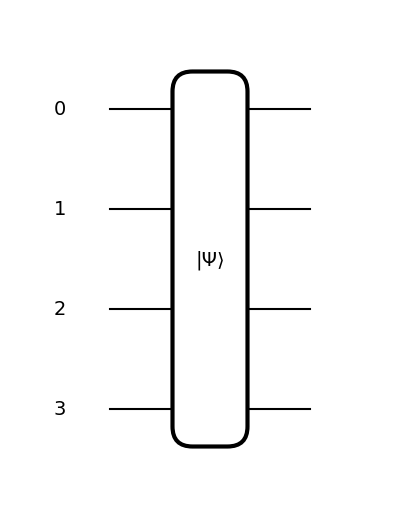

In [27]:
num_qubits = 4
ansatz = "ry ansatze"
if ansatz == "ry ansatz":
    def var_state(params):
        for layer, params_per_layer in enumerate(params):
            for wire in range(num_qubits):
                qml.Rot(*params_per_layer[wire], wires=wire)

            if layer < len(params)-1:
                for wire in range(num_qubits-1):
                    qml.CNOT([wire,wire+1])

    num_layers = 4
    params_init = 0.01 * np.random.randn( num_layers, num_qubits, 3, requires_grad=True)


else: # Use ZGR ansatz instead

    def var_state(params):
        # num_params = sum_{i=0}^{num_qubits} 2^{i} 
        #            = 2^{num_qubits+1} - 1
        qml.AmplitudeEmbedding(params, normalize=True, wires=range(num_qubits))
        '''
        for layer, params_per_layer in enumerate(params):
            qml.RY(params_per_layer[0], wires=0)
            i = 1
            for qubit in range(num_qubits):
                for _ in range(2):
                    for ctrl in range(qubit):
                        qml.CNOT(wires=[ctrl, qubit])
                        qml.RY(params_per_layer[qubit], wires=qubit)
                        i += 1
        '''          
        #return circuit
    '''
    def var_state(params):
    # num_params = sum_{i=0}^{num_qubits} 2^{i} 
    #            = 2^{num_qubits+1} - 1
    for layer, params_per_layer in enumerate(params):
        qml.Rot(*params_per_layer[0], wires=0)
        i = 1
        for qubit in range(num_qubits):
            for _ in range(2):
                for ctrl in range(qubit):
                    qml.CNOT(wires=[ctrl, qubit])
                    qml.Rot(*params_per_layer[qubit], wires=qubit)
                    i += 1
                        
        #return circuit
    '''
    num_layers = 1
    params_init = 0.01 * np.random.randn( 2**(num_qubits) , requires_grad=True)
    #var_state = zgr_ansatz(num_qubits)

qml.draw_mpl(var_state)(params_init)

In [45]:
dev = qml.device( "lightning.qubit", 
                    wires=num_qubits, shots = 1000)

#Xs, Ps = varfourier.grid_op()
def state_in():
    #qml.QubitStateVector(gaussian_GS(Xs)/np.linalg.norm(gaussian_GS(Xs)),wires=[0,1,2])
    pass
varfourier = VarFourier( num_qubits, 
                        lambda x : 0.5 * x**2, 
                        lambda p : 0.5 * p**2,
                        dev,
                        var_state,
                        state_in=state_in, 
                        semi_classical=False,
                        xmin = -5,
                        xmax = +5  )

In [46]:
Xs

NameError: name 'Xs' is not defined

In [47]:
varfourier.energy_eval( params_init )

/home/ctabares/.virtualenvs/qhack/lib/python3.11/site-packages/pennylane/_qubit_device.py:551: UserWarning: Requested measurement MyMP with finite shots; the returned state information is analytic and is unaffected by sampling. To silence this warning, set shots=None on the device.
  warnings.warn(


12.361521395329577

In [38]:
import optax
import jax

max_iterations = 1000
conv_tol = 1e-04

opt = optax.adam(learning_rate=1.0) # ADAM and SPSA are recommended on García-Molina et. al.

In [39]:
qml.gradients.param_shift(varfourier.X_eval())( params_init )

array([-80.28365962, -53.70913673,  47.22355274,   6.9372762 ,
         1.05186245,  44.27048089, -73.32422512, -17.35852426,
        64.82434908,  -6.04254736,  14.16659059,   0.1748661 ,
       -19.73255385,   7.47319999, -34.14781238,  24.40980369])

In [43]:
cost_fn = lambda params : varfourier.X_eval()( np.copy(params) )  + varfourier.P_eval()( np.copy(params) )
grad_fn = lambda params : qml.gradients.param_shift(varfourier.X_eval())( np.copy(params) ) \
                            + qml.gradients.param_shift(varfourier.P_eval())(np.copy(params))

In [48]:
param = params_init
opt_state = opt.init(param)

Params   = [param]
Energies = [cost_fn(param)]

for n in range(max_iterations):

    gradient = grad_fn(param)
    updates, opt_state = opt.update(gradient, opt_state)
    param = optax.apply_updates(param, updates)

    Params.append(param)
    Energies.append(cost_fn(param))

    conv = np.abs(Energies[-1] - Energies[-2])

    if n % 2 == 0:
        print(f"Step = {n},  Energy = {Energies[-1]:.8f} Ha")

    if conv <= conv_tol:
        break

Step = 0,  Energy = 7.78505745 Ha
Step = 2,  Energy = 7.32327453 Ha
Step = 4,  Energy = 6.94139349 Ha
Step = 6,  Energy = 6.64264738 Ha
Step = 8,  Energy = 6.39632464 Ha
Step = 10,  Energy = 6.18597126 Ha
Step = 12,  Energy = 6.00215475 Ha
Step = 14,  Energy = 5.83900654 Ha
Step = 16,  Energy = 5.69262562 Ha
Step = 18,  Energy = 5.56027447 Ha
Step = 20,  Energy = 5.43994173 Ha
Step = 22,  Energy = 5.33008873 Ha
Step = 24,  Energy = 5.22949457 Ha
Step = 26,  Energy = 5.13715829 Ha
Step = 28,  Energy = 5.05223507 Ha
Step = 30,  Energy = 4.97399341 Ha
Step = 32,  Energy = 4.90178657 Ha
Step = 34,  Energy = 4.83503272 Ha
Step = 36,  Energy = 4.77320208 Ha
Step = 38,  Energy = 4.71580747 Ha
Step = 40,  Energy = 4.66239847 Ha
Step = 42,  Energy = 4.61255694 Ha
Step = 44,  Energy = 4.56589440 Ha
Step = 46,  Energy = 4.52205003 Ha
Step = 48,  Energy = 4.48068892 Ha
Step = 50,  Energy = 4.44150147 Ha
Step = 52,  Energy = 4.40420191 Ha
Step = 54,  Energy = 4.36852764 Ha
Step = 56,  Energy = 4.33

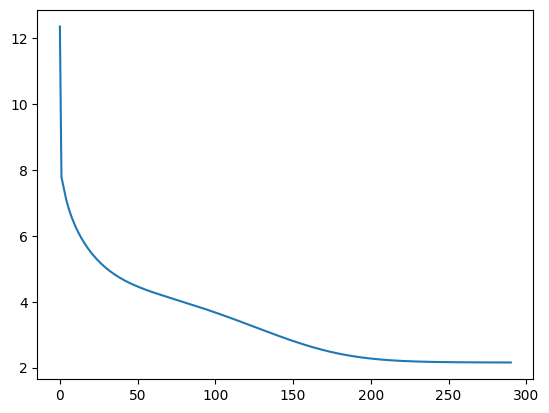

In [49]:
plt.plot( Energies )

In [ ]:
Xs, Ps = varfourier.grid_op()

def gaussian_GS(x):
  return 1/np.pi**(0.25)*np.exp(-x*x / 2)

0.8299921333924053

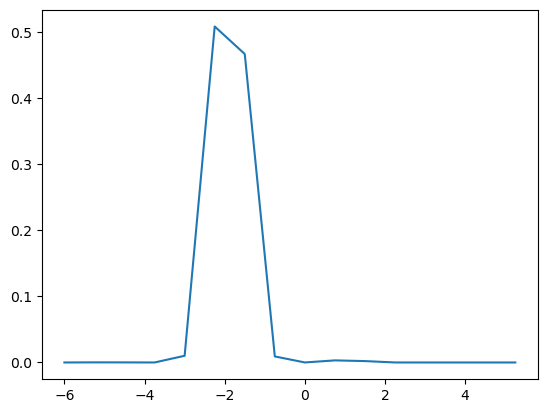

In [ ]:
np.linalg.norm(gaussian_GS(Xs))

In [ ]:
qml.QubitStateVector(gaussian_GS(Xs)/np.linalg.norm(gaussian_GS(Xs)),wires=[0,1,2])

QubitStateVector(tensor([3.37254328e-06, 1.53781233e-03, 9.11032516e-02, 7.01211689e-01,
        7.01211689e-01, 9.11032516e-02, 1.53781233e-03, 3.37254328e-06], requires_grad=True), wires=[0, 1, 2])

In [ ]:
Ps

tensor([ 0.        ,  0.54977871,  1.09955743,  1.64933614, -2.19911486,
        -1.64933614, -1.09955743, -0.54977871], requires_grad=True)

In [ ]:
Params[-1]

Array([[ 1.3898583e-01,  1.4334956e+00,  4.8518986e-02, -1.2214710e-03,
         7.0080520e-03,  6.5410174e-03, -3.0874240e-03]], dtype=float32)

@qml.qnode(dev)
def output_statevec(params):
    # num_params = sum_{i=0}^{num_qubits} 2^{i} 
    #            = 2^{num_qubits+1} - 1
    qml.QubitStateVector(gaussian_GS(Xs)/np.linalg.norm(gaussian_GS(Xs)),wires=[0,1,2])
    for layer, params_per_layer in enumerate(params):
        qml.RY(params_per_layer[0], wires=0)
        i = 1
        for qubit in range(num_qubits):
            for _ in range(2):
                for ctrl in range(qubit):
                    qml.CNOT(wires=[ctrl, qubit])
                    qml.RY(params_per_layer[qubit], wires=qubit)
                    i += 1
                        
        return qml.state()

In [ ]:
output_statevec(Params[-1])

Array([-0.02893247+0.j, -0.6996865 +0.j, -0.03580392+0.j,  0.09099621+0.j,
        0.69951946+0.j,  0.09099014+0.j,  0.00786004+0.j,  0.0486934 +0.j],      dtype=complex64)